In [2]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob
import scipy

In [3]:
# Root directory of the project
ROOT_DIR = 'D:/research/DiabeticPN/Mask_RCNN-master'

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.DiabeticWounds import custom

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

custom_WEIGHTS_PATH = "D:/research/DiabeticPN/Mask_RCNN-master/logs/wound20181211T1521/mask_rcnn_wound_0100.h5"  # TODO: update this path

Using TensorFlow backend.


In [4]:
config = custom.CustomConfig()
custom_DIR = 'D:/research/DiabeticPN/DataSet/MaskRCNNData'

In [5]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [6]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [7]:

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [8]:
# Load validation dataset
dataset = custom.CustomDataSet()
dataset.load_custom(custom_DIR, "val")

# # Must call before using the dataset
dataset.prepare()
print(dataset)

In [9]:
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 187
Classes: ['BG', 'wound']


In [10]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [11]:
# load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)# load the last model you trained
# weights_path = model.find_last()[1]


Loading weights  D:/research/DiabeticPN/Mask_RCNN-master/logs/wound20181211T1521/mask_rcnn_wound_0100.h5
Re-starting from epoch 100


In [12]:
from importlib import reload # was constantly changin the visualization, so I decided to reload it instead of notebook
reload(visualize)

<module 'mrcnn.visualize' from 'D:/research/DiabeticPN/Mask_RCNN-master\\mrcnn\\visualize.py'>

In [25]:
def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or visualize.random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            x = random.randint(x1, (x1 + x2) // 2)
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color,linewidth = 3)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Processing 1 images
image                    shape: (319, 548, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


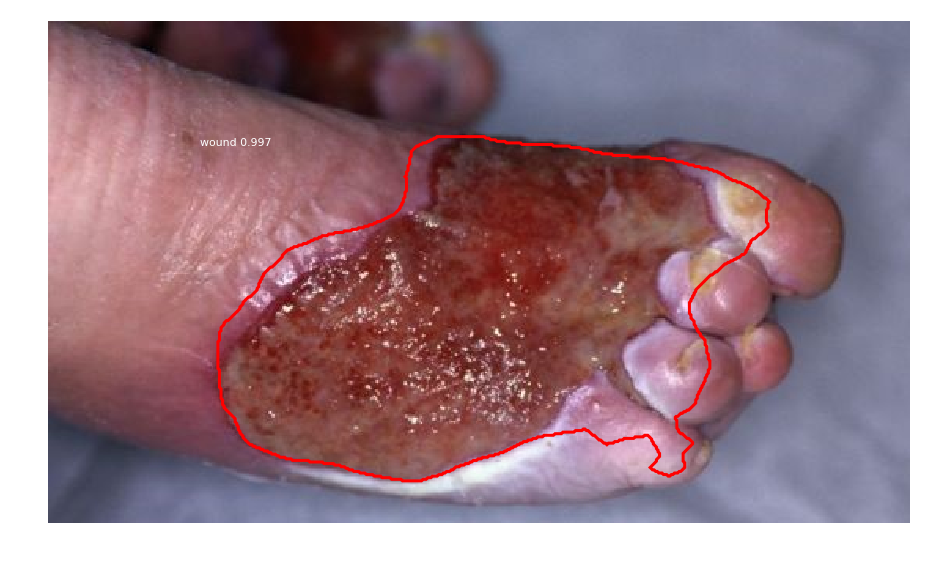

In [26]:
image = scipy.misc.imread('D:/research/DiabeticPN/DataSet/MRCNNData/val/Grade1_41.jpg')
# Run detection
results = model.detect([image], verbose=1)
# Visualize results
r = results[0]
display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'],show_mask=False, show_bbox=False)